In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from tqdm import tqdm
import itertools
import powerlaw

import sys
sys.path.append('../')
from tracker import loadAntData, pltsaveall, discretizeTrajectory

# Update source files before running each cell
%load_ext autoreload
%autoreload 2

From tracker/_init__.py:
SLEAP not detected; make sure to install SLEAP if intending to use postprocessing notebook. Otherwise, ignore this message.


In [2]:
dataFile = '/home/jack/Workspaces/data/ant_tracking/ant_dataset_1_2025-09-20.h5'

minimumLength = 5 # seconds
smoothingWindow = 10 # frames
maximumTimeSkip = 10 # frames

excludeOutliers = True
excludeShortSegments = True
excludeObjects = True

padding = 10 # mm
inversePadding = None # mm

dataArr, timeArr, metadataArr = loadAntData(dataFile, minimumLength, smoothingWindow, maximumTimeSkip,
                                            excludeOutliers, excludeShortSegments, excludeObjects,
                                            padding, inversePadding, debug=True)

Removing trajectories near walls: 100%|██████████████████████████████████████████████████████████████████████████| 494/494 [00:51<00:00,  9.53it/s]

Loaded 1091 segments!


As is emphasized in many other parts of this project, discretizing a continuous trajectory is a very subjective process, so you need to be very careful in choosing your parameters. As such, here we survey a range of parameters, principally the colinearity threshold (`c`) and the velocity threshold (`velocityThreshold`).

In [96]:
# Convert to discrete steps
# Given as a colinearity value, between [0, 1]
cArr = np.linspace(0.2, 0.7, 5)
# The minimum velocity that we use to identify waiting
# periods, in mm/s
velocityThresholdArr = np.linspace(1, 10, 5) # mm/s

# These two arrays give values of each individual parameter
# so the total number of samples is the product of their lengths.

# These parameters are not as important as the ones above, but still
# should be given adequate thought
minDistancePerRun = 4 # mm
minStepsPerRun = 5 # frames

discreteDataArr = []
discreteStepSizeArr = []
waitTimeArr = []
runTimeArr = []

# Since we have two parameters, we should generate
# each pair of parameters.
allParams = np.array(list(itertools.product(cArr, velocityThresholdArr)))

# Replace the above lists
cArr = allParams.T[0]
velocityThresholdArr = allParams.T[1]

for i in range(len(cArr)):
    discreteDataArr.append([])
    discreteStepSizeArr.append([])
    waitTimeArr.append([])
    runTimeArr.append([])

    for j in tqdm(range(len(dataArr))):
        discreteTraj, waitingTimes, runTimes = discretizeTrajectory(dataArr[j],
                                                                    c=cArr[i],
                                                                    velocityThreshold=velocityThresholdArr[i],
                                                                    dt=1/metadataArr[j]["fps"],
                                                                    minSteps=minStepsPerRun,
                                                                    minDistancePerRun=minDistancePerRun,
                                                                    debug=False)
        discreteDataArr[-1].append(discreteTraj)
        
        discreteStepSizeArr[-1].append(np.sqrt(np.sum((discreteTraj[1:] - discreteTraj[:-1])**2, axis=-1)))
        waitTimeArr[-1].append(waitingTimes)
        runTimeArr[-1].append(runTimes)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 1091/1091 [00:12<00:00, 84.53it/s]


## Wait time distribution

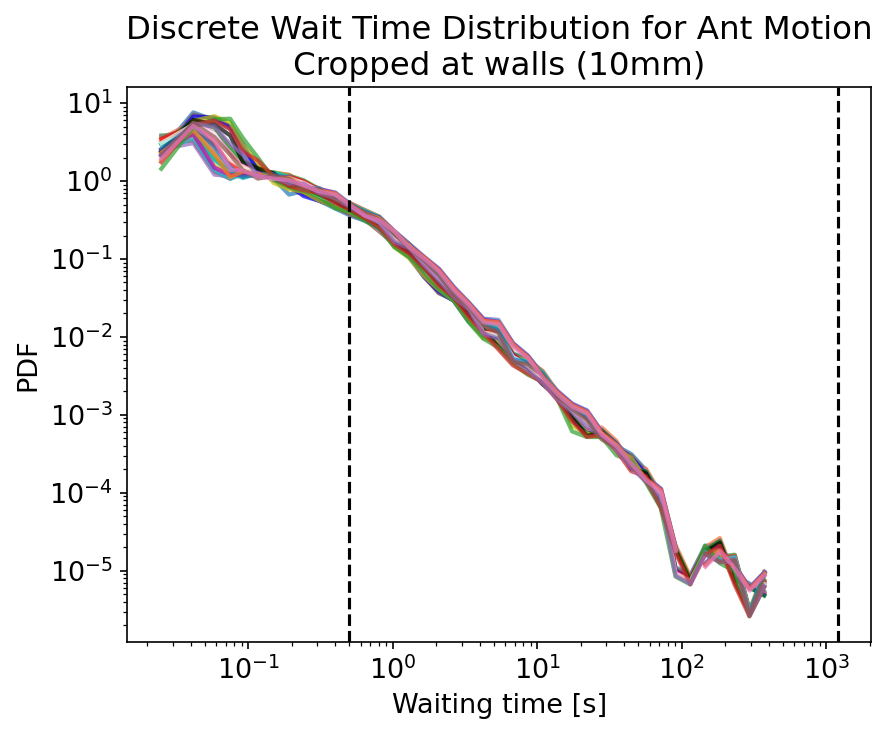

In [112]:
# Minimum time; should be the smallest time we consider
# significant for a discretized run:
xMin = maximumTimeSkip / metadataArr[0]["fps"] * 3
# Maximum time should be the length of a trial
xMax = 1200 # [s], 20 minutes

colors = list(mpl.colors.TABLEAU_COLORS) + list(mpl.colors.BASE_COLORS)

fig, ax = plt.subplots()
alphaArr = np.zeros(len(discreteStepSizeArr))

for i in range(len(discreteStepSizeArr)):
    waitTimes = np.array([t for wt in waitTimeArr[i] for t in wt])
    
    powerlaw.plot_pdf(waitTimes, ax=ax, color=colors[i % len(colors)], label=f'Data, $c = {cArr[i]:.2}$, $v_m = {velocityThresholdArr[i]:.3}$', linewidth=2, alpha=0.7)

plt.axvline(xMin, c='black', linestyle='--')
plt.axvline(xMax, c='black', linestyle='--')

plt.yscale('log')
plt.xscale('log')
plt.ylabel('PDF')
plt.xlabel('Waiting time [s]')
#plt.legend(fontsize=10)
plt.title('Discrete Wait Time Distribution for Ant Motion\nCropped at walls (10mm)')
pltsaveall('11_DiscreteWaitTime_Cropped')
plt.show()

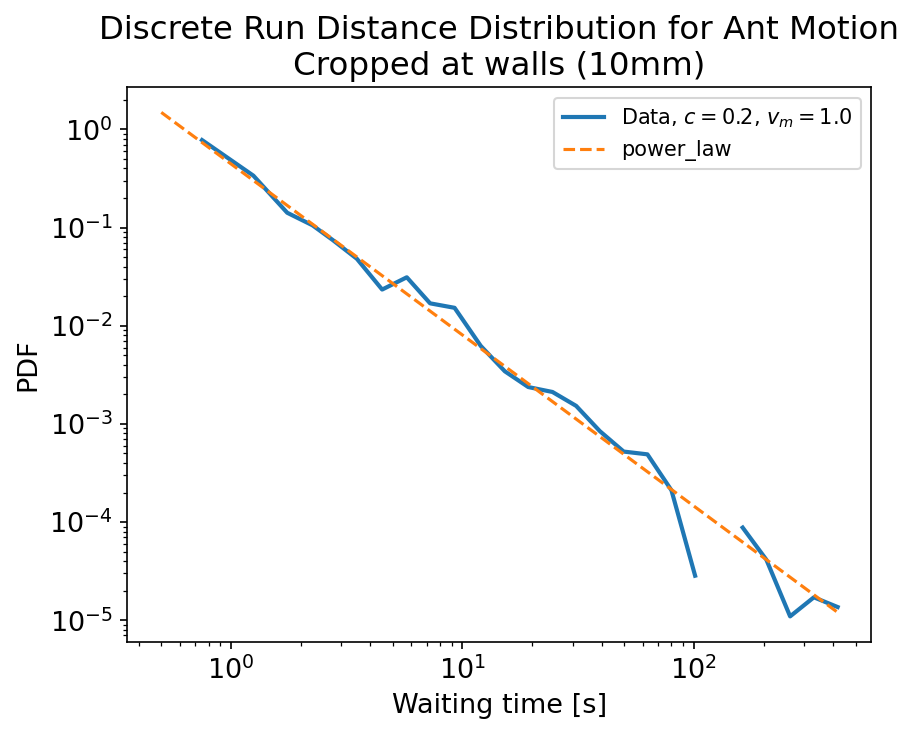

In [121]:
# Minimum time; should be the smallest time we consider
# significant for a discretized run:
xMin = 0.5
# Maximum time should be the length of a trial
xMax = 1200 # [s], 20 minutes

colors = list(mpl.colors.TABLEAU_COLORS) + list(mpl.colors.BASE_COLORS)

fig, ax = plt.subplots()

for i in [0]:#range(len(discreteStepSizeArr)):
    waitTimes = np.array([t for wt in waitTimeArr[i] for t in wt])

    fit = powerlaw.Fit(waitTimes, xmin=xMin, xmax=xMax)
    
    fit.plot_pdf(ax=ax, color=colors[i % len(colors)], label=f'Data, $c = {cArr[i]:.2}$, $v_m = {velocityThresholdArr[i]:.3}$', linewidth=2)
    fit.power_law.plot_pdf(ax=ax, linestyle='--', color=colors[1], label='power_law')

plt.yscale('log')
plt.xscale('log')
plt.ylabel('PDF')
#plt.xlim([None, 1100])
plt.xlabel('Waiting time [s]')
plt.legend(fontsize=10)
#plt.title('Discrete Run Distance Distribution for Ant Motion\nUncropped')
plt.title('Discrete Run Distance Distribution for Ant Motion\nCropped at walls (10mm)')
pltsaveall('11_DiscreteWaitTime_TestFit')
plt.show()

In [114]:
alphaArr = np.zeros(len(discreteStepSizeArr))

for i in range(len(discreteStepSizeArr)):
    waitTimes = np.array([t for wt in waitTimeArr[i] for t in wt])

    fit = powerlaw.Fit(waitTimes, xmin=xMin, xmax=xMax)

    alphaArr[i] = fit.power_law.alpha

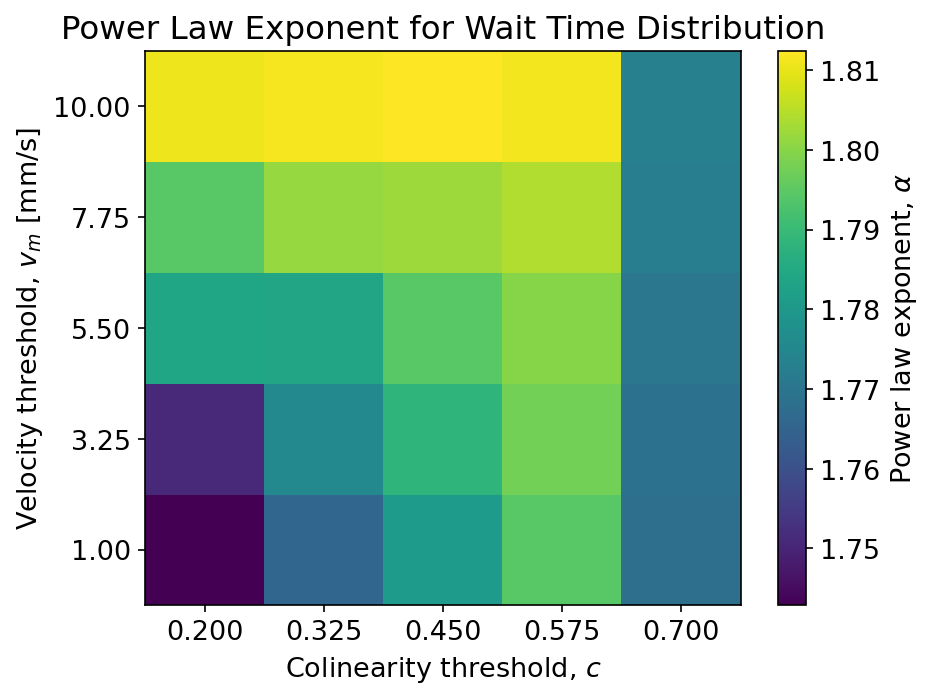

In [126]:
uniqueCArr = np.unique(cArr)
uniqueVArr = np.unique(velocityThresholdArr)

alphaMatrix = alphaArr.reshape((len(uniqueCArr), len(uniqueVArr)))

plt.pcolor(uniqueCArr, uniqueVArr, alphaMatrix)
plt.colorbar(label='Power law exponent, $\\alpha$')
plt.xticks(uniqueCArr)
plt.yticks(uniqueVArr)
plt.xlabel('Colinearity threshold, $c$')
plt.ylabel('Velocity threshold, $v_m$ [mm/s]')
plt.title('Power Law Exponent for Wait Time Distribution')
pltsaveall('11_DiscreteWaitTime_FitParameters')
plt.show()

In [122]:
chosenDistribution = 'power_law'
alternativeDistributions = ['truncated_power_law', 'lognormal', 'exponential', 'stretched_exponential']
comparisonMatrix = np.zeros((len(discreteStepSizeArr), len(alternativeDistributions), 2))

for i in range(len(discreteStepSizeArr)):
    waitTimes = np.array([t for wt in waitTimeArr[i] for t in wt])

    fit = powerlaw.Fit(waitTimes, xmin=xMin, xmax=xMax)
    
    for j in range(len(alternativeDistributions)):
        R, p = fit.distribution_compare(chosenDistribution, alternativeDistributions[j], normalized_ratio=True)
        comparisonMatrix[i,j] = R, p

/home/jack/miniconda3/envs/311/lib/python3.11/site-packages/powerlaw/distributions.py:796: UserWarning: Fitted parameters are very close to the edge of parameter ranges; consider changing these ranges.
  warnings.warn('Fitted parameters are very close to the edge of parameter ranges; consider changing these ranges.')
/home/jack/miniconda3/envs/311/lib/python3.11/site-packages/powerlaw/distributions.py:764: UserWarning: No valid fits found for distribution stretched_exponential.
  warnings.warn(f"No valid fits found for distribution {self.name}.")


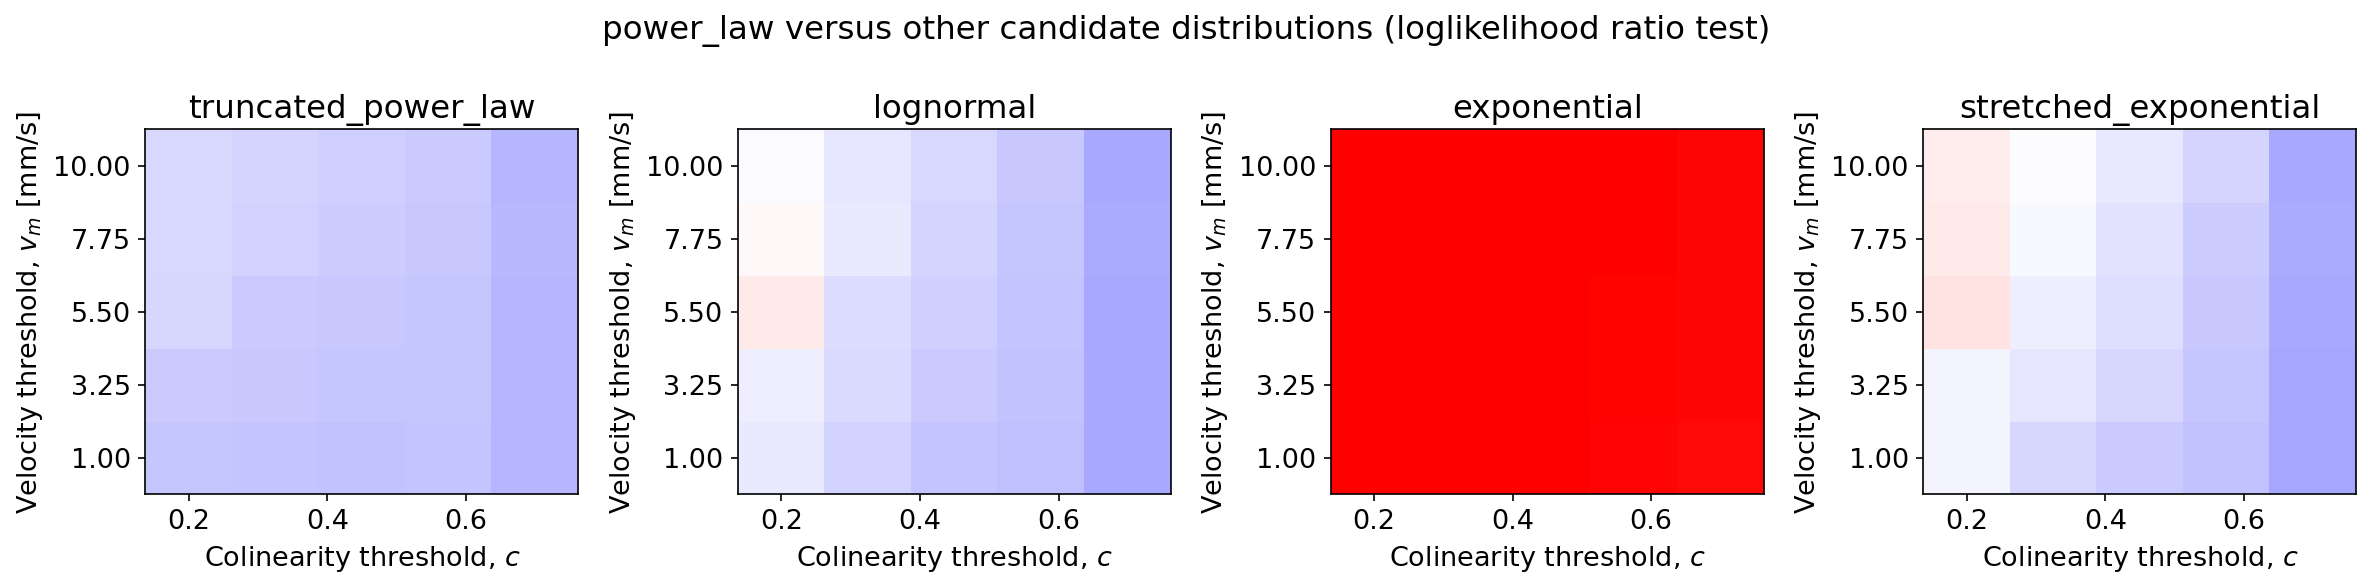

In [123]:
uniqueCArr = np.unique(cArr)
uniqueVArr = np.unique(velocityThresholdArr)

norm = mpl.colors.PowerNorm(1, vmin=-10, vmax=10)
fig, ax = plt.subplots(1, len(alternativeDistributions), figsize=(len(alternativeDistributions)*4, 4))

for i in range(len(alternativeDistributions)):

    paramMatrix = comparisonMatrix[:,i,0].reshape((len(uniqueCArr), len(uniqueVArr)))
    ax[i].pcolor(uniqueCArr, uniqueVArr, paramMatrix, cmap='bwr', norm=norm)
    #plt.xticks(uniqueCArr)
    ax[i].set_yticks(uniqueVArr)
    ax[i].set_xlabel('Colinearity threshold, $c$')
    ax[i].set_ylabel('Velocity threshold, $v_m$ [mm/s]')
    ax[i].set_title(f'{alternativeDistributions[i]}')

fig.suptitle(f'{chosenDistribution} versus other candidate distributions (loglikelihood ratio test)')
fig.tight_layout()
plt.show()

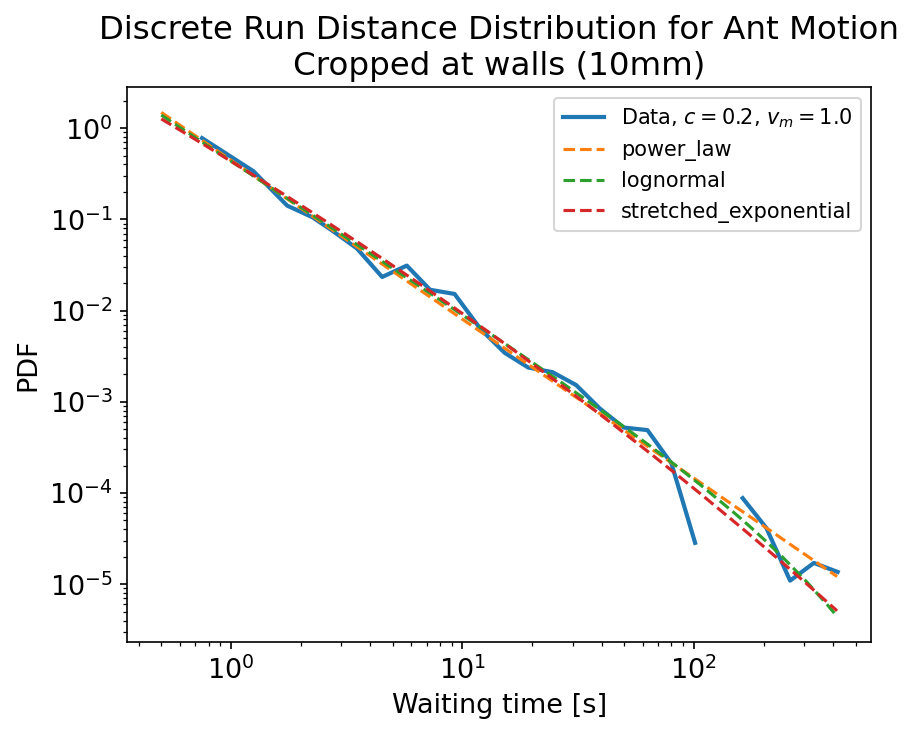

In [125]:
colors = list(mpl.colors.TABLEAU_COLORS) + list(mpl.colors.BASE_COLORS)

fig, ax = plt.subplots()

for i in [0]:#range(len(discreteStepSizeArr)):
    waitTimes = np.array([t for wt in waitTimeArr[i] for t in wt])

    fit = powerlaw.Fit(waitTimes, xmin=xMin, xmax=xMax)
    
    fit.plot_pdf(ax=ax, color=colors[i % len(colors)], label=f'Data, $c = {cArr[i]:.2}$, $v_m = {velocityThresholdArr[i]:.3}$', linewidth=2)
    fit.power_law.plot_pdf(ax=ax, linestyle='--', color=colors[1], label='power_law')
    fit.truncated_power_law.plot_pdf(ax=ax, linestyle='--', color=colors[2], label='lognormal')
    fit.stretched_exponential.plot_pdf(ax=ax, linestyle='--', color=colors[3], label='stretched_exponential')

plt.yscale('log')
plt.xscale('log')
plt.ylabel('PDF')
#plt.xlim([None, 1100])
plt.xlabel('Waiting time [s]')
plt.legend(fontsize=10)
#plt.title('Discrete Run Distance Distribution for Ant Motion\nUncropped')
plt.title('Discrete Run Distance Distribution for Ant Motion\nCropped at walls (10mm)')
#pltsaveall('11_DiscreteWaitTime_TestFit')
plt.show()